In [1]:
import yfinance as yf
import math
from nselib import capital_market
import seaborn as sbn
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import date
from datetime import datetime
from math import sqrt
import warnings
warnings.filterwarnings("ignore")


In [8]:
end_date = date.today()
today_date = datetime.now().strftime('%d-%m-%Y')
# data = capital_market.price_volume_data('JWL', period='1y')

sym=input("Enter Stock Symbol (NSE listed) : ")
sym = str(sym)
data = capital_market.price_volume_data(symbol=sym, period='1y')
# sym = input("Enter stock symbol : ")
sym2 = str(sym) + '.NS'
stock = yf.Ticker(sym2)
info_dict = stock.info
key_list = ['symbol','quoteType','longName','city','website','industry','fullTimeEmployees','previousClose','open','dayLow','dayHigh','fiftyTwoWeekHigh',
            'dividendRate','dividendYield','marketCap','trailingPE','forwardPE','trailingEps','forwardEps','enterpriseToEbitda','debtToEquity','returnOnEquity',
            'revenuePerShare','ebitdaMargins','currentPrice','targetHighPrice','targetLowPrice','recommendationKey']
new_info_dict={}
counter = 0
for key, value in info_dict.items():
    # print(key)
    if key in key_list:
        counter += 1
        new_info_dict[key] = value
d = len(new_info_dict)
# print(d)
# print(type(new_info_dict.keys))
k = new_info_dict.keys()
# print(k)

print(type(k))
for key in new_info_dict.keys():
    if key == 'recommendationKey':
        rec = str(new_info_dict['recommendationKey'])
    if key == 'ebitdaMargins':
        ebitda_margin = float(new_info_dict['ebitdaMargins'])
    if key == 'trailingEps':
        teps = float(new_info_dict['trailingEps'])
    if key == 'forwardEps':
        feps = float(new_info_dict['forwardEps'])
    else:
        feps=teps
    if key == 'forwardPE':
        f_pe = float(new_info_dict['forwardPE'])
    else:
        f_pe = 0
    if key == 'trailingPE':
        t_pe = float(new_info_dict['trailingPE'])

df = pd.DataFrame([new_info_dict])
df.style


            

<class 'dict_keys'>


,city,website,industry,fullTimeEmployees,previousClose,open,dayLow,dayHigh,trailingPE,marketCap,fiftyTwoWeekHigh,trailingEps,enterpriseToEbitda,quoteType,symbol,longName,currentPrice,recommendationKey,debtToEquity,revenuePerShare,returnOnEquity,ebitdaMargins
0,Ahmedabad,https://www.adanigreenenergy.com,Utilities - Renewable,1436,1641.350000,1647.000000,1636.050000,1677.000000,222.269700,2637093142528,1762.050000,7.490000,49.297000,EQUITY,ADANIGREEN.NS,Adani Green Energy Limited,1664.800000,none,719.113000,59.820000,0.177090,0.764800


0
197
50
MSE =  1505.4250341732302
RMSE =  38.799807140928294


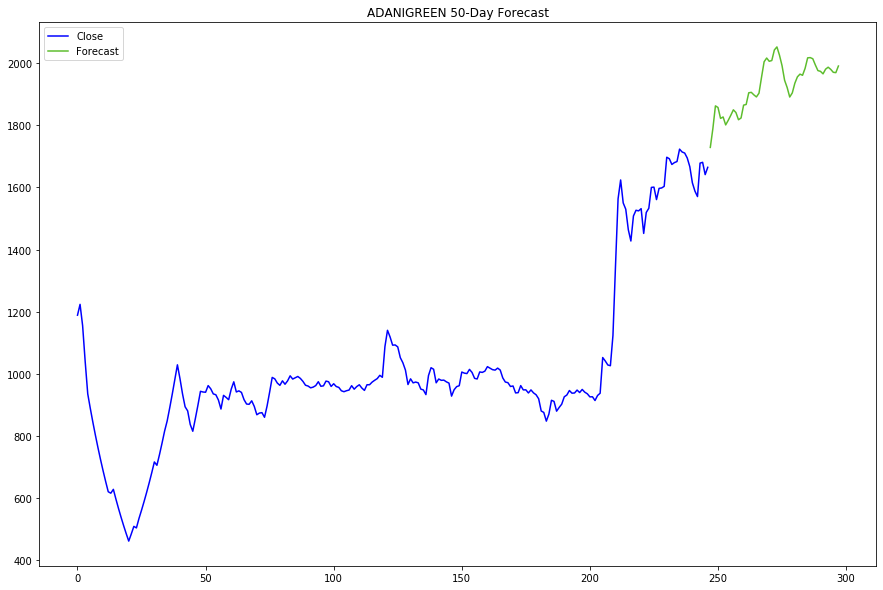

In [3]:

# data = capital_market.price_volume_data(symbol=sym, from_date='01-01-2023', to_date=today_date)
data = capital_market.price_volume_data(symbol=sym, period='1Y')

df = pd.DataFrame({'Date':data['Date'], 'Close':data['ClosePrice']})
l = len(df)
flag = 1
for i in range(l):
    if type(df['Close'][i]) != np.float64:
        flag = 0
print(flag)

if flag == 0:
    df['Close'] = df['Close'].str.replace(',', '').astype(float)
if flag == 1:
    df['Close'] = df['Close'].replace(',', '').astype(float)

# print(df['Close'])
# sbn.lineplot(x=df.index, y = df['Close'])
# plt.show()

stepwise_fit = auto_arima(df['Close'], suppress_warnings=True)
stepwise_fit.summary()

n = len(df['Close'])
train_size = int(n * 0.80)
#train test split
train_set = df.iloc[:train_size]
test_set = df.iloc[train_size:]
print(len(train_set))
print(len(test_set))

model = ARIMA(df['Close'], order = (31,2,31))
model_fit = model.fit()
model_fit.summary()

#predict on test set
start_point = len(train_set)
end_point = len(train_set) + len(test_set) - 1
pred = model_fit.predict(start= start_point, end = end_point, type='levels').rename('ARIMA predictions')
# pred.plot(legend=True)
# test_set['Close'].plot(legend=True)

mse = mean_squared_error(pred, test_set['Close'])
print("MSE = ",mse)
rmse = math.sqrt(mse)
print("RMSE = ",rmse)

#Future trend 
future = model_fit.predict(start= len(df), end= len(df)+50, type='levels').rename("Forecast")
# print(future)

plt.figure(figsize=(15,10))
df['Close'].plot(color = 'blue', legend=True)
# future.plot(legend=True, title=f"{sym} 50-Day Forecast")
flg = 0
if future[len(df) + 50] > future[len(df)]:
    flg = 1
if flg == 1:
    future.plot(color='#5dbd2d', legend=True, title=f"{sym} 50-Day Forecast")
else:
    future.plot(color = 'red', legend=True, title=f"{sym} 50-Day Forecast")

# , title=f"{symbol}"
# print(type(future))



In [9]:
weight_sum = 0
bal_sheet = stock.balance_sheet
row_index='Total Capitalization'
w=0
#weight = 3
c = len(bal_sheet.columns)
print(c)
for i in range(c):
    if (float(bal_sheet.loc[row_index,bal_sheet.columns[i]]) - float(bal_sheet.loc[row_index,bal_sheet.columns[i]])) > 0:
        w += 1
    else:
        w -= 1
print(w)
weight_sum += w


#weight = 3
row_index='Total Assets'
w=0
c = len(bal_sheet.columns)
print(c)
for i in range(c):
    if (float(bal_sheet.loc[row_index,bal_sheet.columns[i]]) - float(bal_sheet.loc[row_index,bal_sheet.columns[i]])) > 0:
        w += 1
    else:
        w -= 1
print(w)
weight_sum += w


# print(type(future[250]))
s0 = len(train_set) + len(test_set)
s1 = s0 + 10
s2 = s0 + 20
s3 = s0 + 30
s4 = s0 + 40
s5 = s0 + 50
def slope(x,y):
    m = (future[y] - future[x])/ (y-x)
    return m
m1 = slope(s0,s1)
m2 = slope(s0,s2)
m3 = slope(s0,s3)
m4 = slope(s0,s4)
m5 = slope(s0,s5)
fc = (m1 + m2 + m3 + m4 + m5)/5

#weight = 30
if (fc > 0) and (fc <= 1):
    weight_sum += 30
elif (fc > 1):
    weight_sum += 60
if (fc < 0) and (fc >= -0.5):
    weight_sum -= 30
elif (fc < -0.5):
    weight_sum -= 60  
#weight = 5
if(rec == 'strong_buy'):
    weight_sum+=10
elif (rec == 'buy'):
    weight_sum+=5
else:
    weight_sum-=10

#weight = 5
if (f_pe > t_pe):
    weight_sum += 5
else:
    weight_sum -= 5
    
#weight = 3
pe = (f_pe + t_pe)/2
if (pe > 10)and(pe < 25):
    weight_sum += 3
else:
    weight_sum -= 3
    
#weight = 5
if feps > teps:
    weight_sum += 5
else:
    weight_sum -= 5

#weigth = 3
if ebitda_margin > 0.10 :
    weight_sum += 3
else:
    weight_sum -= 3
    
# #weight = 3
# def DE(s):
#     stock = yf.Ticker(s)
#     bal = stock.balance_sheet
#     total_debt = bal['Total_Debt'].iloc[0]
#     total_equity = bal['Total_Equity'].iloc[0]
#     de_ratio = total_debt/total_equity
#     return de_ratio
# de = DE(sym2)
    
#weight = 3
cash_flo=stock.cash_flow
w=0
c = len(cash_flo.columns)
print(c)
row_index='Free Cash Flow'
for i in range(c):
    v = float(cash_flo.loc[row_index, cash_flo.columns[i]])
    if v > 0:
        w += 3
    else:
        w-=3
weight_sum += w

F_ind = (weight_sum)/61
print(F_ind)

if F_ind <= -0.15:
    print("SELL")
elif (F_ind > -0.15)and(F_ind < 0.15):
    print("HOLD")
elif (F_ind >= 0.15) and (F_ind < 0.50):
    print("BUY")
elif(F_ind >= 0.50):
    print("STRONG BUY")
# cash_flo.style

4
-4
4
-4
4
0.4262295081967213
BUY


In [ ]:

print(stock.get_earnings_trend())

In [10]:
cash_flo.style

,2023-03-31 00:00:00,2022-03-31 00:00:00,2021-03-31 00:00:00,2020-03-31 00:00:00
Free Cash Flow,-222535100000.000000,28052200000.000000,-36731000000.000000,-17840300000.000000
Repayment Of Debt,-23243000000.000000,nan,nan,nan
Issuance Of Debt,nan,6386000000.000000,8191000000.000000,81097000000.000000
Issuance Of Capital Stock,nan,0.000000,1101600000.000000,82934000000.000000
Capital Expenditure,-9829600000.000000,-34051300000.000000,-27860500000.000000,-33033700000.000000
End Cash Position,1023733900000.000000,1302286000000.000000,1286611300000.000000,1310050700000.000000
Beginning Cash Position,1302286000000.000000,1286611300000.000000,1310050700000.000000,978848400000.000000
Changes In Cash,-278552100000.000000,15674700000.000000,-23439400000.000000,331202300000.000000
Other Cash Adjustment Inside Changein Cash,nan,nan,0.000000,170112300000.000000
Financing Cash Flow,-54884000000.000000,-9978100000.000000,-9855000000.000000,147286700000.000000
